In [12]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [5]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

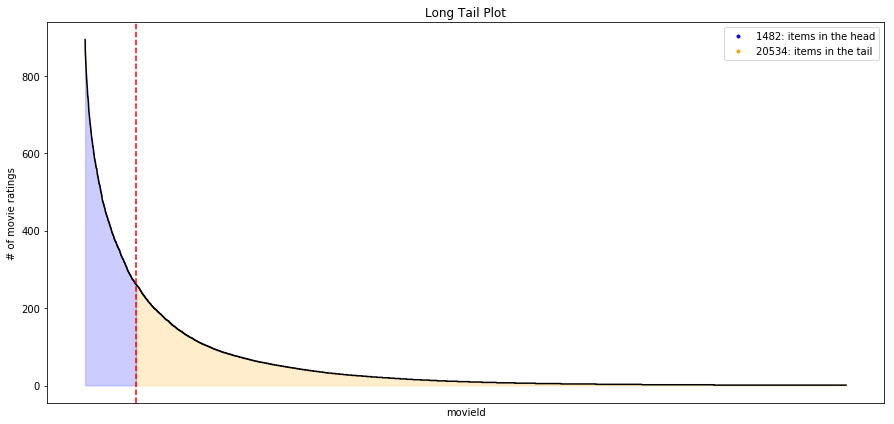

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [13]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [14]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [15]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,118205,6890,4.0,3.559073
1,101861,5603,5.0,4.279317
2,16676,4973,4.0,4.136634
3,135186,2324,3.5,4.174073
4,35037,6581,3.5,3.693948


In [ ]:
#evaluate model with MSE and RMSE
print recmetrics.mse(test.actual, test.cf_predictions)
print recmetrics.rmse(test.actual, test.cf_predictions)

In [16]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [17]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [18]:
#get example prediction
get_users_predictions(156, 10, cf_model)

[1291, 5952, 1961, 1036, 1610, 3578, 1221, 953, 919, 4306]

In [19]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
#make recommendations for all members in the test data
recs = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recmetrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,actual,cf_predictions
userId,,
156,"[1, 2049, 2056, 2057, 2058, 6156, 15, 2065, 41...","[1291, 5952, 1961, 1036, 1610, 3578, 1221, 953..."
208,"[3072, 6659, 517, 3083, 55820, 60333, 3088, 30...","[923, 858, 3739, 912, 1252, 3134, 903, 296, 52..."
359,"[514, 4011, 6149, 4103, 1032, 4105, 522, 48385...","[2959, 58559, 608, 4993, 745, 3030, 1304, 1225..."
394,"[514, 1963, 3588, 1542, 5641, 2058, 3083, 5633...","[3089, 111, 1228, 1208, 4226, 3030, 1148, 1213..."
572,"[34048, 69122, 516, 5541, 1034, 2571, 2572, 46...","[2571, 58559, 1234, 1291, 68358, 2804, 1270, 3..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [20]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
156,"[1, 2049, 2056, 2057, 2058, 6156, 15, 2065, 41...","[1291, 5952, 1961, 1036, 1610, 3578, 1221, 953...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[3072, 6659, 517, 3083, 55820, 60333, 3088, 30...","[923, 858, 3739, 912, 1252, 3134, 903, 296, 52...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[514, 4011, 6149, 4103, 1032, 4105, 522, 48385...","[2959, 58559, 608, 4993, 745, 3030, 1304, 1225...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
394,"[514, 1963, 3588, 1542, 5641, 2058, 3083, 5633...","[3089, 111, 1228, 1208, 4226, 3030, 1148, 1213...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
572,"[34048, 69122, 516, 5541, 1034, 2571, 2572, 46...","[2571, 58559, 1234, 1291, 68358, 2804, 1270, 3...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [21]:
#make recommendations for all members in the test data

recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
156,"[1, 2049, 2056, 2057, 2058, 6156, 15, 2065, 41...","[1291, 5952, 1961, 1036, 1610, 3578, 1221, 953...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[4936, 383, 25825, 6614, 1676, 1041, 84152, 55..."
208,"[3072, 6659, 517, 3083, 55820, 60333, 3088, 30...","[923, 858, 3739, 912, 1252, 3134, 903, 296, 52...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[2463, 1344, 6127, 1374, 7889, 106920, 1191, 9..."
359,"[514, 4011, 6149, 4103, 1032, 4105, 522, 48385...","[2959, 58559, 608, 4993, 745, 3030, 1304, 1225...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[1374, 3617, 31, 1894, 141, 832, 86237, 2539, ..."
394,"[514, 1963, 3588, 1542, 5641, 2058, 3083, 5633...","[3089, 111, 1228, 1208, 4226, 3030, 1148, 1213...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[7234, 2700, 78976, 7569, 4919, 5497, 1303, 72..."
572,"[34048, 69122, 516, 5541, 1034, 2571, 2572, 46...","[2571, 58559, 1234, 1291, 68358, 2804, 1270, 3...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[3471, 58740, 25891, 1788, 3763, 81100, 89285,..."


# Recall

In [22]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [23]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007172178387604512,
 0.001163541405000544,
 0.0014754431430776813,
 0.0017870858170277132,
 0.0020708131343422902,
 0.0022904174572579016,
 0.0025384620090280014,
 0.002774361934949963,
 0.0030072482605942503,
 0.003224430435941276]

In [24]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0002893561795059058,
 0.0004202760986393777,
 0.0005059227623355991,
 0.0005814770619000432,
 0.0006397769431826604,
 0.0007001989870676219,
 0.0007542068856134802,
 0.0007932968967469147,
 0.0008389135837292566,
 0.0008740375405887791]

In [25]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.003075722507651412,
 0.006151445015302824,
 0.009227167522954235,
 0.012302890030605649,
 0.01537861253825706,
 0.01845433504590847,
 0.021530057553559884,
 0.024605780061211297,
 0.027681502568862704,
 0.03075722507651412]

# Mark Plot

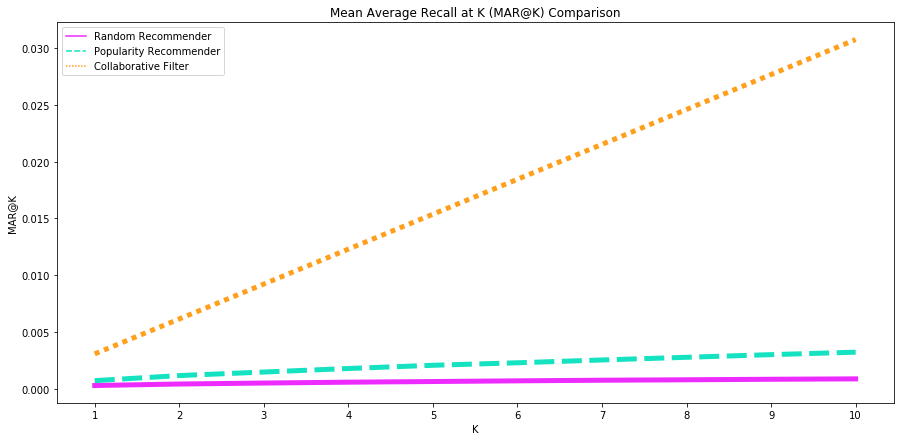

In [26]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [27]:
catalog = ratings.movieId.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

# Coverage Plot

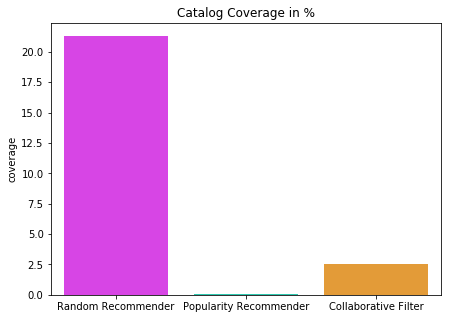

In [28]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.CoveragePlot(coverage_scores, model_names)

# Personalization

In [29]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [30]:
recmetrics.personalization(predicted=example_predictions)

0.9166666666666666

# Intra-list Similarity

In [31]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [32]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [33]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.27777777777777773